# Quantifying river channel evolution HW

### From the original notebook
The equation at hand
$$
\begin{equation}
 \frac{d z}{d t} = -K_\text{sp} A^{m_{sp}} S^{n_{sp}} + U
\end{equation}
$$
Here, $K_{sp}$ is the erodibility coefficient on fluvial incision, which is thought to be positively correlated with climate wetness, or storminess (this is hard to quantify) and to be negatively correlated with rock strength (again, rock strength is hard to quantify). $m_{sp}$ and $n_{sp}$ are positive exponents, usually thought to have a ratio, $m_{sp}/n_{sp} \approx 0.5$. $A$ is drainage area and $S$ is the slope of steepest descent ($-\frac{dz}{dx}$) where $x$ is horizontal distance (positive in the downslope direction) and $z$ is elevation. (If slope is negative there is no fluvial erosion.) $U$ is an externally-applied rock uplift rate field.

The fluvial erosion term is also known as the stream power equation. Before using this notebook you should be familiar with this equation from class lectures and reading. 

### I addapted the code to make it more comfortable to me

In [43]:
# imports

import copy
import numpy as np
from matplotlib import pyplot as plt

from landlab import RasterModelGrid, imshow_grid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
)
from landlab.io import write_esri_ascii

In [88]:
# global parameters
params = { "timer":0 }
raster = 0
raster2= 0

In [89]:
# set parameters function
def set_params( tmax=5e5, uplift_rate = 0.0001, **kwargs):
    """set some parameters. All parameters can be set by passing the **kwargs if needed"""
    params["rows"] = 50
    params["columns"] = 100
    params["dxy"] = 200
    params["timer"] = 0
    params["uplift_rate"] = uplift_rate
    params["dt"] = 1000
    params["tmax"] = tmax
    params["K_sp"] = 1.0e-5
    params["m_sp"] = 0.5
    params["n_sp"] = 1.0
    params["fault_location"] = 4000
    params["low_uplift_rate"] = 0.0001
    params["high_uplift_rate"] = 0.0004

    if kwargs:
        print("additional parameters passed")
        for key in kwargs:
            params[key]=kwargs[key]
# run at least once
set_params()

In [90]:
# reset grid, flow route tools, eroder and all landlab tools
def reset_grid():
    """
    reset grid, flow route tools, eroder and all landlab tools.
    
    Returns the raster and the associated topography, flow_router, stream_eroder,steep_finder,chi_finder 
    """
    raster = RasterModelGrid((params["rows"], params["columns"]), params["dxy"])
    raster.set_closed_boundaries_at_grid_edges(True, True, True, False)
    np.random.seed(35)
    noise = np.random.rand(raster.number_of_nodes) / 1000.0
    topography = raster.add_zeros("topographic__elevation", at="node")
    topography += noise
    flow_router = FlowAccumulator(raster, flow_director='FlowDirectorD8')
    flow_router.run_one_step()
    stream_eroder = StreamPowerEroder(raster, K_sp=params["K_sp"], 
                            m_sp=params["m_sp"], n_sp=params["n_sp"],
                            threshold_sp=0.0)
    params["theta"] = params["m_sp"] / params["n_sp"]
    steep_finder = SteepnessFinder(raster, reference_concavity=params["theta"], min_drainage_area=1000.0)
    chi_finder = ChiFinder(raster,
                min_drainage_area=1000.0,
                reference_concavity=params["theta"],
                use_true_dx=True)
    return (raster, topography, flow_router, stream_eroder, steep_finder, chi_finder)
# run at least once
raster, z, frr, spr, sf, cf = reset_grid()

def copy_raster_grid(zs):
    """
    make a copy of a landscape grid, flow route tools, eroder and all landlab tools.
    It copies the first raster. For Hw purposes copy only after running 'raster' to steady state
    
    Returns copy of the raster and the associated topography, flow_router, stream_eroder,steep_finder,chi_finder 
    """
    raster2 = RasterModelGrid((params["rows"], params["columns"]), params["dxy"])
    raster2.set_closed_boundaries_at_grid_edges(True, True, True, False)
    
    topography = raster2.add_field("topographic__elevation", copy.copy(zs), at="node")
    flow_router = FlowAccumulator(raster2, flow_director='FlowDirectorD8')
    flow_router.run_one_step()
    stream_eroder = StreamPowerEroder(raster2, K_sp=params["K_sp"], 
                            m_sp=params["m_sp"], n_sp=params["n_sp"],
                            threshold_sp=0.0)
    params["theta"] = params["m_sp"] / params["n_sp"]
    steep_finder = SteepnessFinder(raster2, reference_concavity=params["theta"], min_drainage_area=1000.0)
    chi_finder = ChiFinder(raster2,
                min_drainage_area=1000.0,
                reference_concavity=params["theta"],
                use_true_dx=True)
    return (raster2, topography, flow_router, stream_eroder, steep_finder, chi_finder)
# run at least once
raster2, z2, frr2, spr2, sf2, cf2 = copy_raster_grid(raster.at_node["topographic__elevation"])

def channel_profiler(raster):
    return ChannelProfiler(raster,
                      number_of_watersheds=3,
                      main_channel_only=True,
                      minimum_channel_threshold=params["dxy"]**2)


In [103]:
# Evolve the system
def evolve(time = 0, omit_times = True):
    """evolve function for the initial steady state topography"""
    if ("tmax" in params.keys()) and (not time):
        time = params["tmax"]
    iterations = len(np.arange(0, time, params["dt"]))
    for ti in range(iterations):
        uplift = np.ones(raster.number_of_nodes) * params["uplift_rate"]
        z[raster.core_nodes] += uplift[raster.core_nodes] * params["dt"]
        frr.run_one_step()
        spr.run_one_step(params["dt"])
        params["timer"] += params["dt"]
        if not omit_times:
            print(params["timer"])
    print(params["timer"])

def evolve_2(time = 0, omit_times = True, scenario = "constant", **kwargs):
    """
    evolve function for raster2. It implements the different scenarios
    
    scenarios can be "constant",  "2 constant" and "gradient"
    """
    if ("tmax" in params.keys()) and (not time):
        time = params["tmax"]
    
    uplift_rate = np.ones(raster2.number_of_nodes)
    match scenario:
        case "constant":
            uplift_rate = uplift_rate * params["uplift_rate"]
            pass
        case "2 constant":
            fault_location = params["fault_location"]
            uplift_rate[np.nonzero(raster2.node_y<fault_location)] = params["low_uplift_rate"]
            uplift_rate[np.nonzero(raster2.node_y>=fault_location)] = params["high_uplift_rate"]
        case "gradient":
            uplift_rate_gradient = (params["high_uplift_rate"] - params["low_uplift_rate"])/(params["rows"]-3)
            uplift_rate = params["low_uplift_rate"] + ((raster2.node_y / params["dxy"])-1) * uplift_rate_gradient
    
    iterations = len(np.arange(0, time, params["dt"]))
    for ti in range(iterations):
        z2[raster2.core_nodes] += uplift_rate[raster2.core_nodes] * params["dt"]
        frr2.run_one_step()
        spr2.run_one_step(params["dt"])
        params["timer"] += params["dt"]
        if not omit_times:
            print(params["timer"])
    print(params["timer"])
    
def earthquake(uplift_amount = 10):
    z2[np.nonzero(raster2.node_y>params["fault_location"])] += uplift_amount


In [92]:
# plotting functions
def plot_topography(raster):
    plt.figure()
    imshow_grid(raster,
                "topographic__elevation",
                grid_units=("m", "m"),
                var_name="Elevation (m)")
    title_text = f'K_{{sp}}={params["K_sp"]}; U={params["uplift_rate"]*1000} mm/yr; time={params["timer"]/1000} kyr'
    plt.title(title_text)
    max_elev = np.max(raster.at_node["topographic__elevation"])
    print("Maximum elevation is ", max_elev)

def plot_slopes_area(raster):
    plt.figure()
    plt.loglog(
        raster.at_node["drainage_area"][np.where(raster.node_y[raster.core_nodes]>200)],
        raster.at_node["topographic__steepest_slope"][np.where(raster.node_y[raster.core_nodes]>200)],
        "b.",
    )
    plt.ylabel("Topographic slope")
    plt.xlabel("Drainage area (m^2)")
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr'

    plt.title(title_text)

def plot_profiles(channel_profiler, raster):
    plt.figure()
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr'
    channel_profiler.plot_profiles(xlabel='distance upstream (m)',
                    ylabel='elevation (m)',
                    title=title_text)
    ax=plt.gca()
    ax.invert_xaxis()

    plt.figure()
    channel_profiler.plot_profiles_in_map_view()

    # slope-area data in just the profiled channels
    plt.figure()
    for i, outlet_id in enumerate(channel_profiler.data_structure):
        for j, segment_id in enumerate(channel_profiler.data_structure[outlet_id]):
            if j == 0:
                label = "channel {i}".format(i=i + 1)
            else:
                label = '_nolegend_'
            segment = channel_profiler.data_structure[outlet_id][segment_id]
            profile_ids = segment["ids"]
            color = segment["color"]
            plt.loglog(
                raster.at_node["drainage_area"][profile_ids],
                raster.at_node["topographic__steepest_slope"][profile_ids],
                '.',
                color=color,
                label=label,
            )

    plt.legend(loc="lower left")
    plt.xlabel("drainage area (m^2)")
    plt.ylabel("channel slope [m/m]")
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr'
    plt.title(title_text)

def plot_chi(channel_profiler, raster, cf, omit_profiles = False):
    cf.calculate_chi()

    if not omit_profiles:
        # chi-elevation plots in the profiled channels
        plt.figure()

        for i, outlet_id in enumerate(channel_profiler.data_structure):
            for j, segment_id in enumerate(channel_profiler.data_structure[outlet_id]):
                if j == 0:
                    label = "channel {i}".format(i=i + 1)
                else:
                    label = '_nolegend_'
                segment = channel_profiler.data_structure[outlet_id][segment_id]
                profile_ids = segment["ids"]
                color = segment["color"]
                plt.plot(
                    raster.at_node["channel__chi_index"][profile_ids],
                    raster.at_node["topographic__elevation"][profile_ids],
                    color=color,
                    label=label,
                )

        ax=plt.gca()
        ax.invert_xaxis()
        plt.xlabel("chi index (m)")
        plt.ylabel("elevation (m)")
        plt.legend(loc="upper right")
        title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]} m/yr; $time$={params["timer"]/1000} kyr; concavity={params["m_sp"]/params["n_sp"]}'
        plt.title(title_text)

    # chi map
    plt.figure()
    imshow_grid(
        raster,
        "channel__chi_index",
        grid_units=("m", "m"),
        var_name="Chi index (m)",
        cmap="jet",
    )
    title_text = f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]} m/yr; $time$={params["timer"]/1000} kyr; concavity={params["m_sp"]/params["n_sp"]}'
    plt.title(title_text)

def plot_steepness(channel_profiler, raster, sf, omit_profiles = False):
    sf.calculate_steepnesses()

    if not omit_profiles:
        plt.figure()

        for i, outlet_id in enumerate(channel_profiler.data_structure):
            for j, segment_id in enumerate(channel_profiler.data_structure[outlet_id]):
                if j == 0:
                    label = "channel {i}".format(i=i + 1)
                else:
                    label = '_nolegend_'
                segment = channel_profiler.data_structure[outlet_id][segment_id]
                profile_ids = segment["ids"]
                distance_upstream = segment["distances"]
                color = segment["color"]
                plt.plot(
                    distance_upstream,
                    raster.at_node["channel__steepness_index"][profile_ids],
                    'x',
                    color=color,
                    label=label,
                )

        ax=plt.gca()
        ax.invert_xaxis()
        plt.xlabel("distance upstream (m)")
        plt.ylabel("steepness index")
        plt.legend(loc="upper right")
        plt.title(f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr; concavity={params["m_sp"]/params["n_sp"]}')

    # channel steepness map
    plt.figure()
    imshow_grid(
        raster,
        "channel__steepness_index",
        grid_units=("m", "m"),
        var_name="Steepness index ",
        cmap="jet",
    )
    plt.title(f'$K_{{sp}}$={params["K_sp"]}; $U$={params["uplift_rate"]*1000} mm/yr; $time$={params["timer"]/1000} kyr; concavity={params["m_sp"]/params["n_sp"]}')

In [ ]:
# workflow example
set_params()
raster, z, frr, spr, sf, cf = reset_grid()
# evolve the landscape by some time
evolve()
# plot topography
plot_topography(raster)
# get channel profiles
prf = channel_profiler(raster)
prf.run_one_step()
# plot stuff
plot_profiles(prf, raster)
plot_chi(prf, raster, cf)
plot_steepness(prf, raster, sf)

### HW problems


After running every code block once, has the landscape reached steady state? Answer: NO! How do you know? After you think about this, you are ready to complete this project.

Answer the following questions using the code above and below. All answers should be typed, and supporting figures (produced using the code) should be embedded in one document that you hand in. Code Blocks 8-12 and 18-21 produce different figures that you may find useful. You can use any or all of these different figures to help you with the questions below. (Download or screenshoot the figures.) 

Anything with a question mark should be answered in the document that you hand in. Make sure your write in full sentences and proofread the document that you hand in.


#### 1. **Steady state with low uplift rate.** 

*Using the parameters provided in the initial notebook, run the landscape to steady state. How did you know that the landscape reached steady state? Note the approximate time that it took to reach steady state for your own reference. Include appropriate plots.*

- Once more, I looked at the steepness index to determine if steady state was reached. Since it seemed it was farily constant at 1.5ma I then look if there were noticeable changes to the other plots. This made me choose 2ma instead as the change from 2ma to 2.5ma was significantly less pronounced than from 1.5ma to 2ma, but then not so much after. 

2000000
Maximum elevation is  73.8606549457


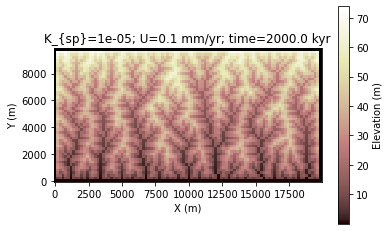

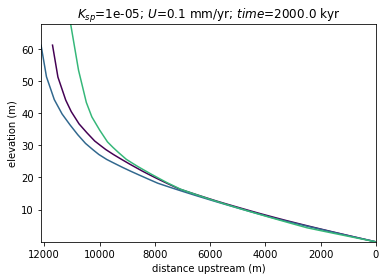

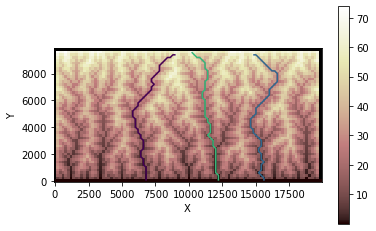

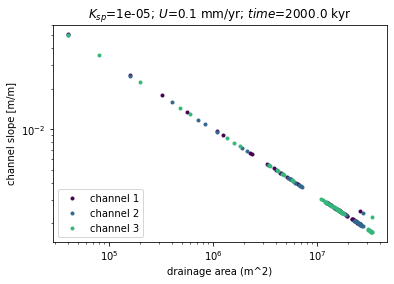

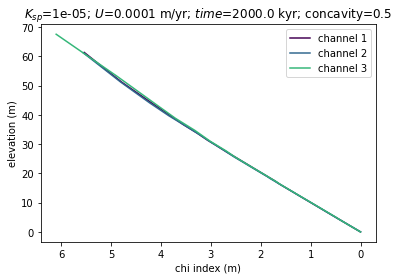

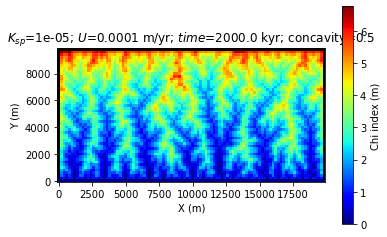

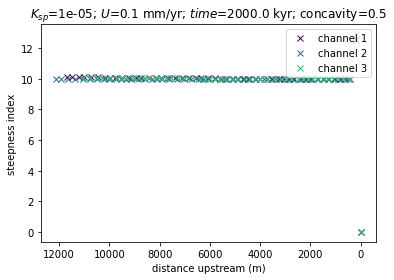

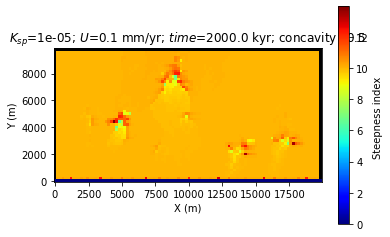

In [93]:
set_params()
raster, z, frr, spr, sf, cf = reset_grid()
# evolve the landscape to steady state from the time obtained by trial and error.
evolve(time= 2e6)
# plot topography
plot_topography(raster)
# get channel profiles
prf = channel_profiler(raster)
prf.run_one_step()
# plot stuff
plot_profiles(prf, raster)
plot_chi(prf, raster, cf)
plot_steepness(prf, raster, sf)

#### 2. **Transient landscape responding to an increase in rock uplift.** 
Use the base landscape and increase rock uplift uniformly by a factor of 4 to 0.0004 m/yr. Make sure you update the rock uplift rate and ensure that $tmax$ is 1e5 yrs and $dt$ is 500 yrs (Code Block 15). Run this until the maximum elevation in the grid is ~ 170 m and observe how the landscape gets to this elevation, i.e. plot intermediate steps. What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a landscape response to uniform increase in rock uplift rate? (You may need to answer this after completing all of the questions.)


additional parameters passed
Maximum elevation is  73.8606549457
100000
Maximum elevation is  103.868482557
200000
Maximum elevation is  133.87844153
300000
Maximum elevation is  163.888729044
400000
Maximum elevation is  193.859364073
500000
Maximum elevation is  223.117377021


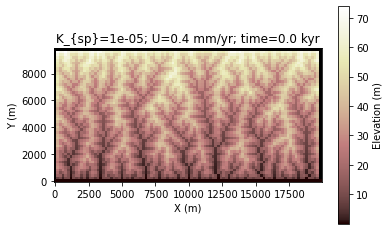

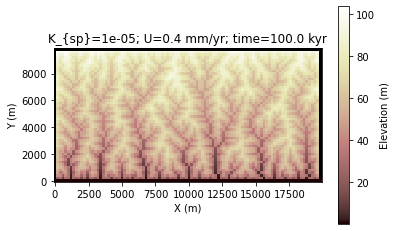

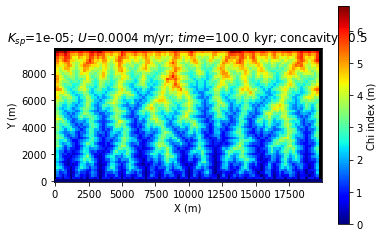

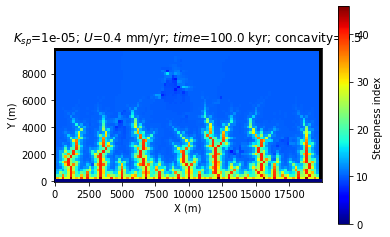

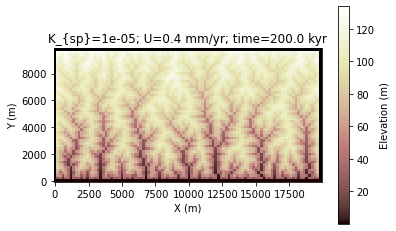

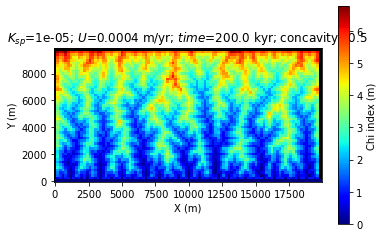

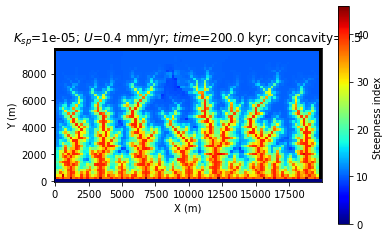

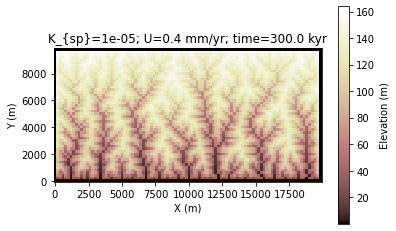

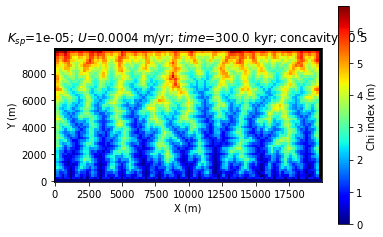

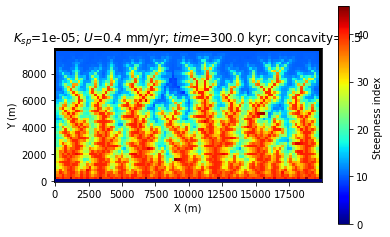

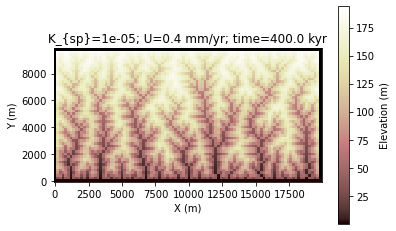

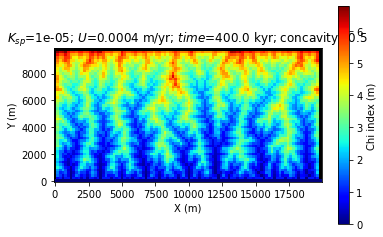

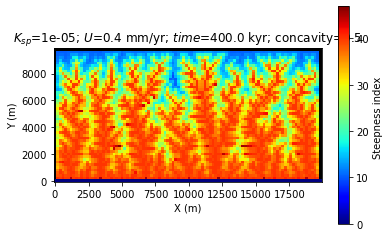

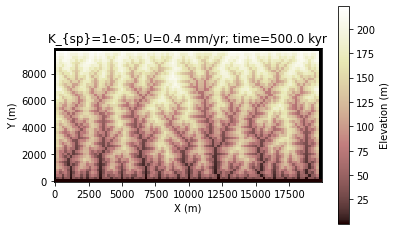

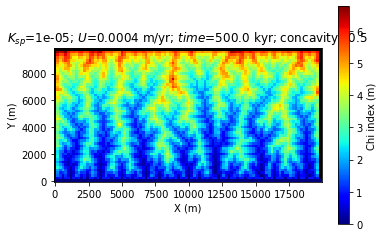

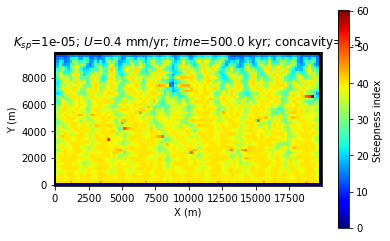

In [76]:
set_params(tmax=1e5, dt = 500, uplift_rate=0.0004)
raster2, z2, frr2, spr2, sf2, cf2 = copy_raster_grid(raster.at_node["topographic__elevation"])
# evolve the landscape to max elevation > 170 m
plot_topography(raster2)
for iter in range(5):
    evolve_2()
    # plot topography
    plot_topography(raster2)
    prf2 = channel_profiler(raster2)
    prf2.run_one_step()
    # plot stuff
    plot_chi(prf2, raster2, cf2, omit_profiles=True)
    plot_steepness(prf2, raster2, sf2, omit_profiles=True)

#### 3. **Steady-state landscape with increased rock uplift.** 
*Now run the landscape from question 2 until it reaches steady state. Provide a plot that illustrates that the landscape is in steady state. What aspects of the landscape have changed in comparison with the base landscape from question 1?*

- The elevations have increased 4-fold along with slopes, relief, and the steepness index. The chi index doesn't seem to change that much.

Maximum elevation is  223.117377021
2000000
Maximum elevation is  295.594626673


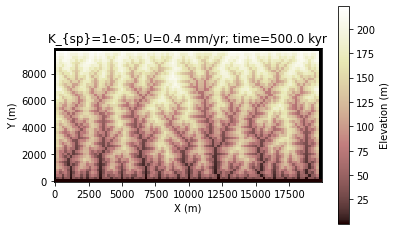

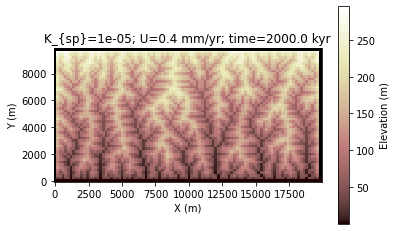

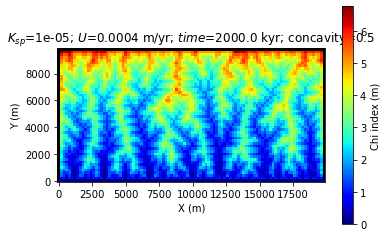

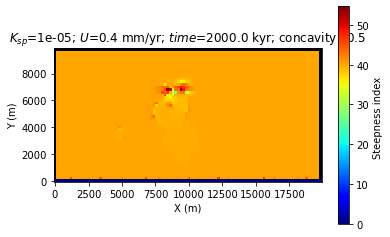

In [77]:
plot_topography(raster2)
evolve_2(time=1.5e6)
# plot topography
plot_topography(raster2)
prf2 = channel_profiler(raster2)
prf2.run_one_step()
# plot stuff
plot_chi(prf2, raster2, cf2, omit_profiles=True)
plot_steepness(prf2, raster2, sf2, omit_profiles=True)

#### 4. **Increase erodibility.** 
Start again from the base landscape, but this time increase $K_{sp}$ to 2E-5. Make sure rock uplift rate is set to the original value of 0.0001 m/yr . Set $tmax$ to 1e5 yrs. Run for 1e5 yrs and save the plots that you think are diagnostic. Run for another 1e5 yrs and save plots again. Now run for 5e5 yrs and save plots again. Quantitatively describe how the landscape evolves in response to the increase in erodibility and provide supporting plots. What could cause a uniform increase in erodibility?


additional parameters passed
Maximum elevation is  73.8606549457
100000
Maximum elevation is  63.8784500827
200000
Maximum elevation is  53.907002703
700000
Maximum elevation is  37.0186504514


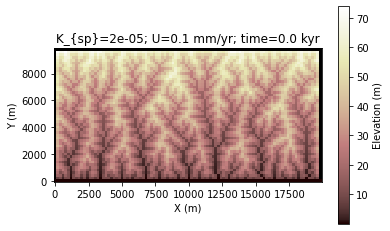

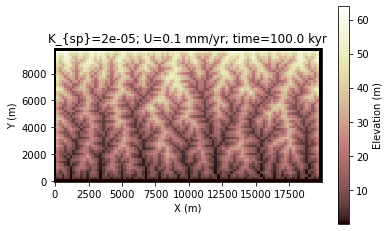

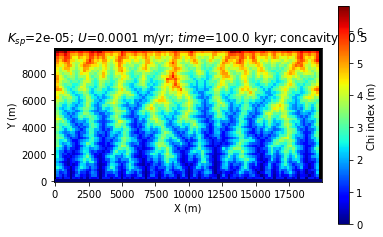

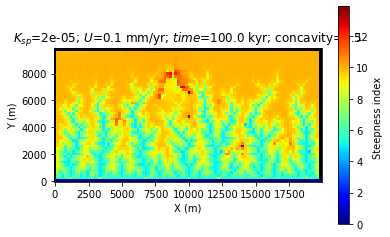

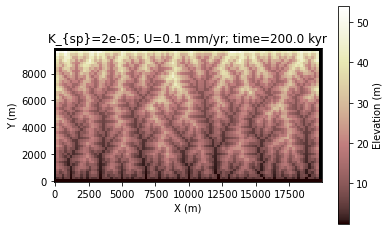

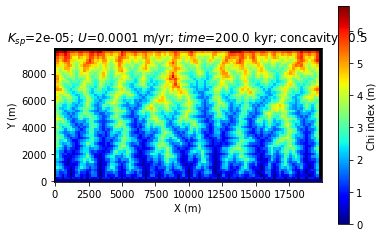

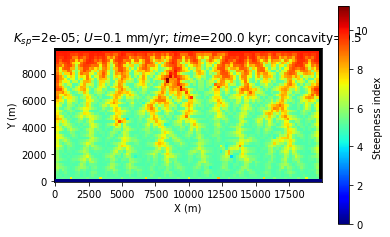

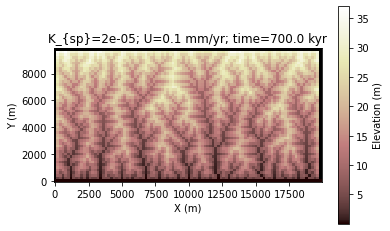

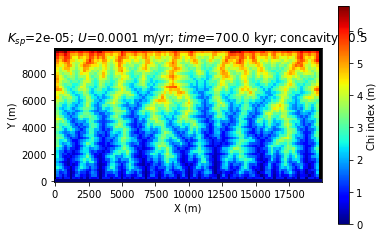

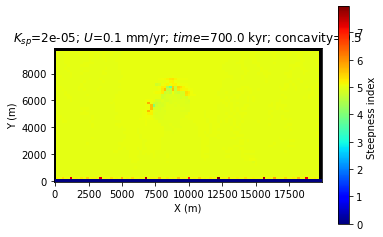

In [79]:
set_params(tmax=1e5, dt = 1000, uplift_rate=0.0001, K_sp = 2e-5)
raster2, z2, frr2, spr2, sf2, cf2 = copy_raster_grid(raster.at_node["topographic__elevation"])
plot_topography(raster2)

times = [1e5, 1e5, 5e5]
for time in times:
    evolve_2(time= time)
    # plot topography
    plot_topography(raster2)
    # plot stuff
    plot_chi(1, raster2, cf2, omit_profiles=True)
    plot_steepness(1, raster2, sf2, omit_profiles=True)

#### 5. **Spatially varible uplift - discrete, massive earthquake.**
Start again from the base landscape, and make sure that $K_{sp}$ = 1E-5 . Now add a seismic event to this steady state landscape - a fault that runs horizontally across the landscape at y = 4000 m, and instantaneously uplifts half the landscape by 10 meters. In this case, we will keep background uplift uniform at 0.0001 m/yr. Set $tmax$ to 1e5 yrs and $dt$ to 500 yrs before evolving the landscape after the fault. Now run the time loop four times and look at the different plots after each loop. How does the landscape respond to this fault? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to an earthquake? (You may need to answer this after completing all of the questions.)

additional parameters passed
Maximum elevation is  73.8606549457
Maximum elevation is  83.8606549457


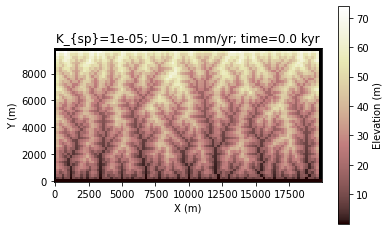

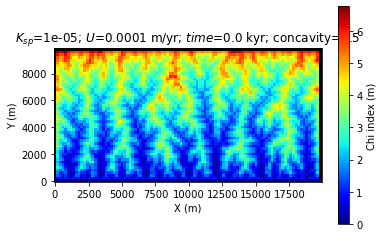

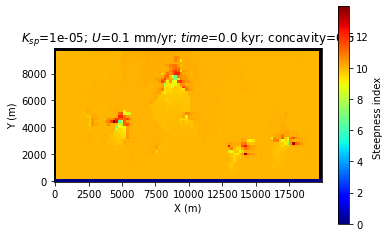

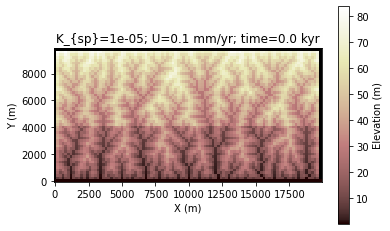

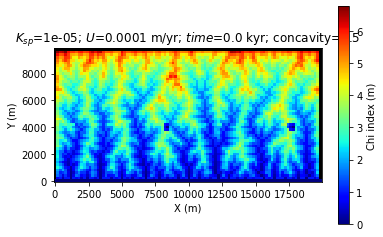

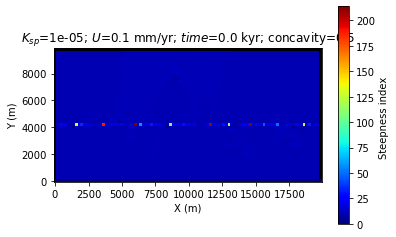

In [97]:
set_params(tmax=1e5, dt = 500, uplift_rate=0.0001, K_sp = 1e-5)
raster2, z2, frr2, spr2, sf2, cf2 = copy_raster_grid(raster.at_node["topographic__elevation"])

plot_topography(raster2)
plot_chi(1, raster2, cf2, omit_profiles=True)
plot_steepness(1, raster2, sf2, omit_profiles=True)

earthquake()

plot_topography(raster2)
frr2.run_one_step()
plot_chi(1, raster2, cf2, omit_profiles=True)
plot_steepness(1, raster2, sf2, omit_profiles=True)

100000
Maximum elevation is  83.8684825547
200000
Maximum elevation is  83.8781278237
300000
Maximum elevation is  83.8348536734
400000
Maximum elevation is  83.2095810241


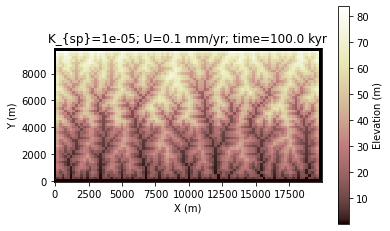

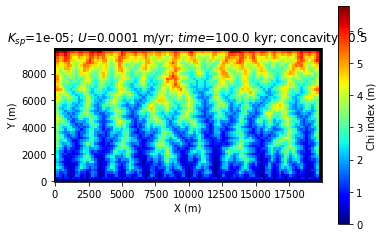

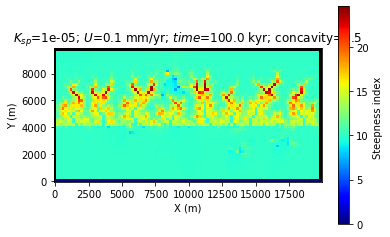

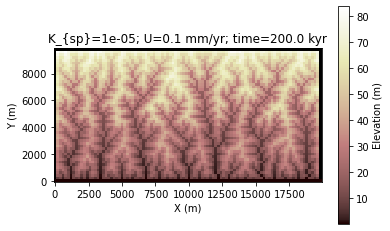

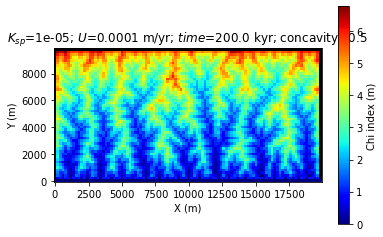

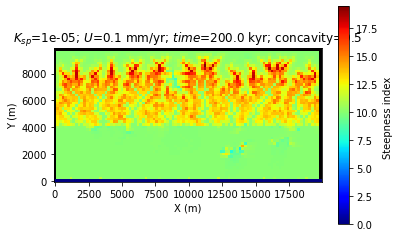

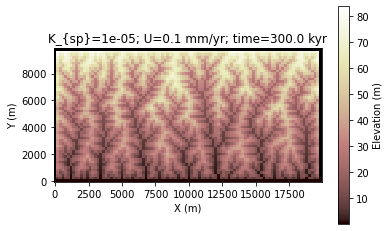

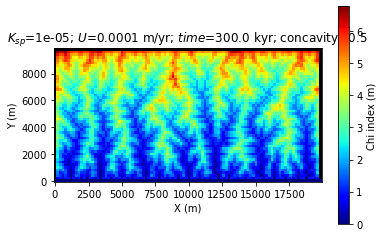

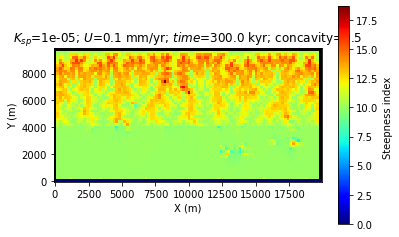

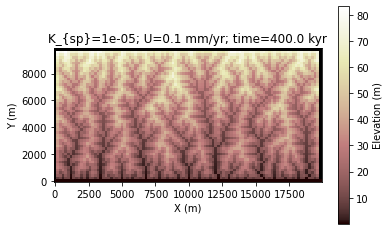

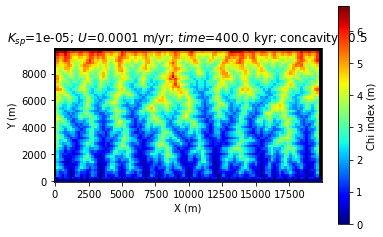

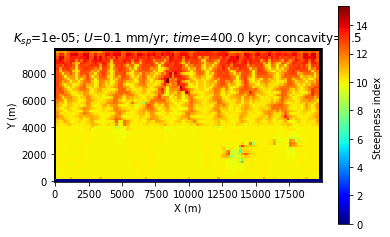

In [98]:
times = [1e5, 1e5, 1e5, 1e5]
for time in times:
    evolve_2(time= time)
    # plot topography
    plot_topography(raster2)
    # plot stuff
    plot_chi(1, raster2, cf2, omit_profiles=True)
    plot_steepness(1, raster2, sf2, omit_profiles=True)

#### 6. **Spatially Varible Rock Uplift - discrete fault with two different uplift rates.**
Start again from the base landscape, and make sure that $K_{sp}$ = 1E-5. Now we will add a fault (at y = 4000 m) to this landscape. In this case the uplift rate on the footwall is higher (0.0004 m/yr) than on the hanging wall (uplift rate = 0.0001 m/yr). Set $tmax$ to 1e5 yrs and $dt$ to 500 yrs. Now run the time loop four separate times and look at the different plots after each loop. How does the landscape respond to this fault? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to a this type of gradient in rock uplift rates? (You may need to answer this after completing all of the questions.)

additional parameters passed
Maximum elevation is  73.8606549457
Maximum elevation is  83.8606549457


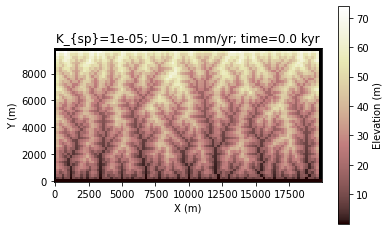

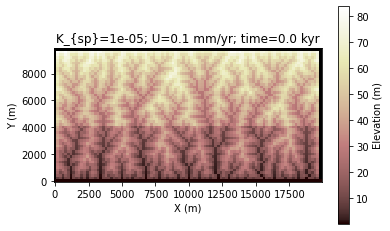

In [106]:
set_params(tmax=1e5, dt = 500, uplift_rate=0.0001, K_sp = 1e-5)
raster2, z2, frr2, spr2, sf2, cf2 = copy_raster_grid(raster.at_node["topographic__elevation"])

plot_topography(raster2)
earthquake()
plot_topography(raster2)

100000
Maximum elevation is  113.868482555
200000
Maximum elevation is  143.878056232
300000
Maximum elevation is  173.805030935
400000
Maximum elevation is  202.458349043


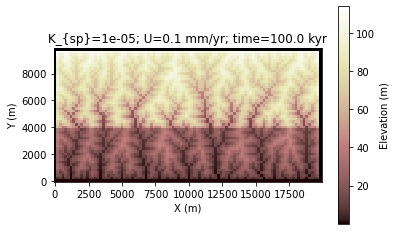

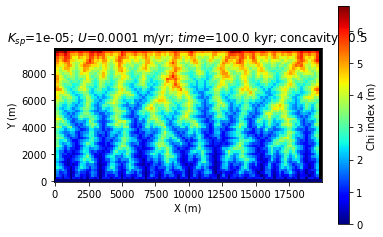

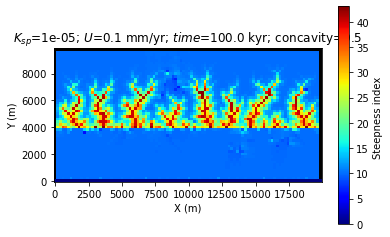

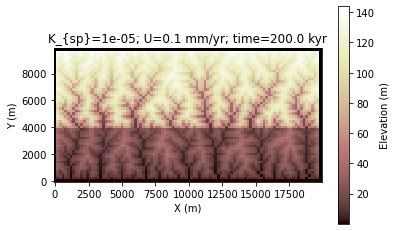

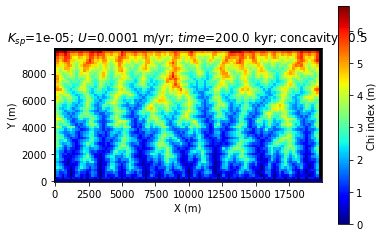

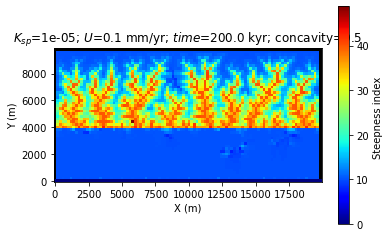

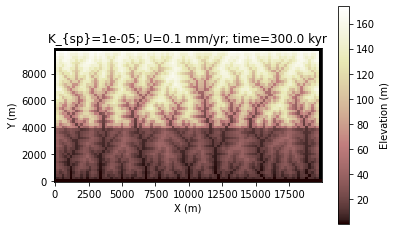

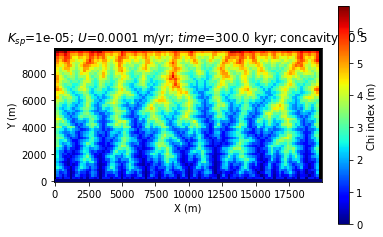

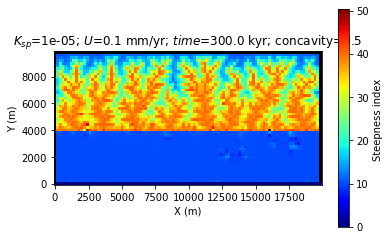

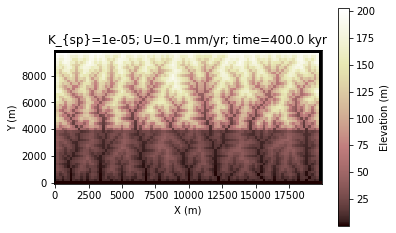

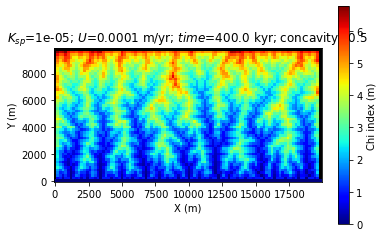

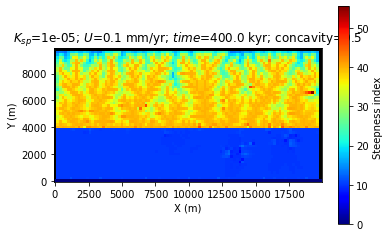

In [107]:
times = [1e5, 1e5, 1e5, 1e5]
for time in times:
    evolve_2(time= time, scenario="2 constant")
    # plot topography
    plot_topography(raster2)
    # plot stuff
    plot_chi(1, raster2, cf2, omit_profiles=True)
    plot_steepness(1, raster2, sf2, omit_profiles=True)


#### 7. **Spatially Varible Rock Uplift - gradient in uplift across the range.** 

Start again from the base landscape, and make sure that $K_{sp}$ = 1E-5 (Code Block 14). Now we will add a linear gradient in uplift rate across the entire range (edit Code Block 16). The maximum uplift rate will be 0.0004 m/yr at the core of the range, and 0.0001 m/yr at the front of the range. Set $tmax$ to 1e5 yrs (Code Block 4) and $dt$ to 500 yrs before you start running the time loop for the fault before you start running the time loop with the rock uplift gradient. Now run the time loop four separate times and look at the different plots after each loop. How does the landscape respond to this gradient in uplift rate? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to this type of gradient in rock uplift rates? (You may need to answer this after completing all of the questions.)

additional parameters passed
Maximum elevation is  73.8606549457
Maximum elevation is  83.8606549457


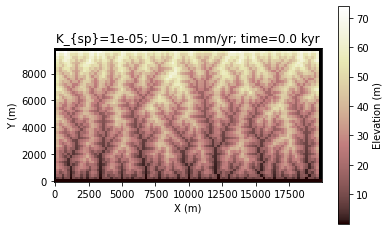

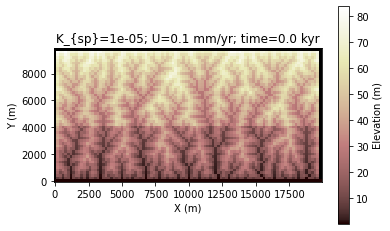

In [108]:
set_params(tmax=1e5, dt = 500, uplift_rate=0.0001, K_sp = 1e-5)
raster2, z2, frr2, spr2, sf2, cf2 = copy_raster_grid(raster.at_node["topographic__elevation"])

plot_topography(raster2)
earthquake()
plot_topography(raster2)

100000
Maximum elevation is  113.564402333
200000
Maximum elevation is  142.316002257
300000
Maximum elevation is  169.401198478
400000
Maximum elevation is  193.284163823


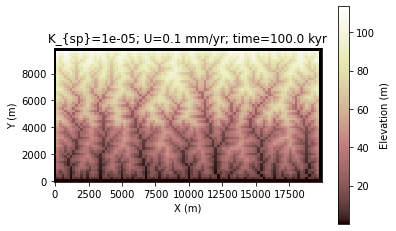

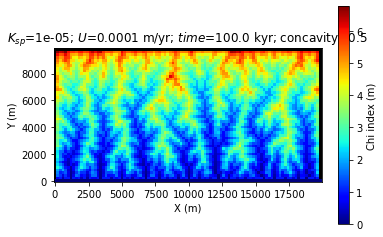

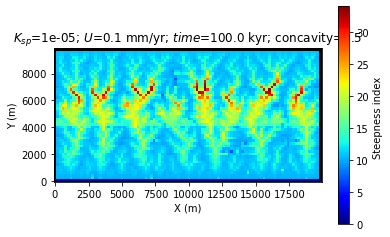

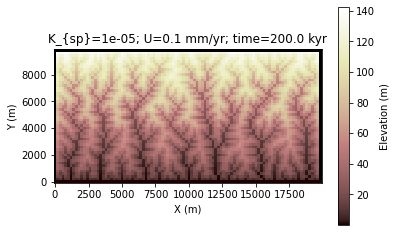

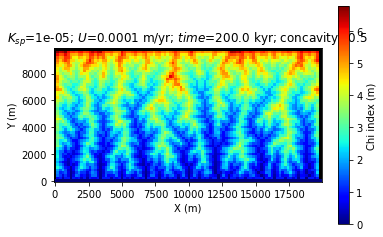

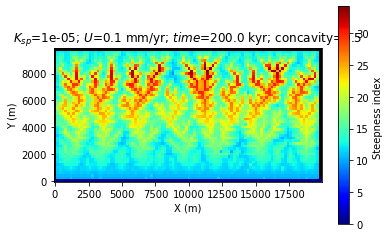

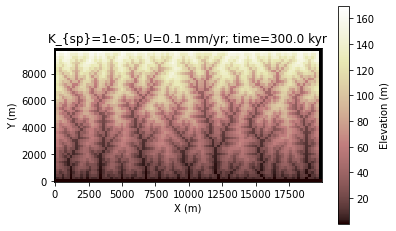

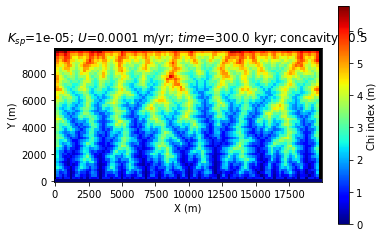

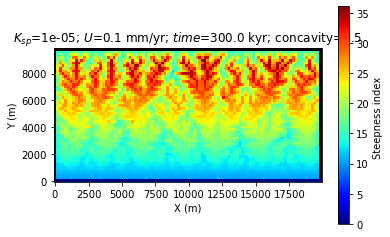

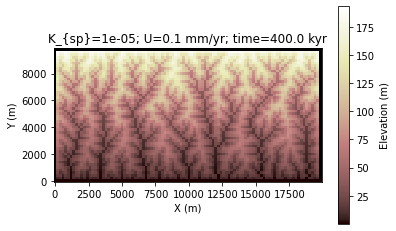

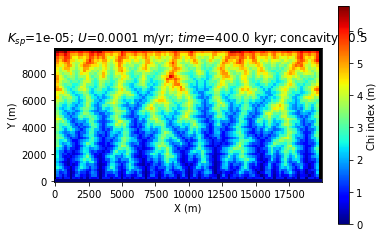

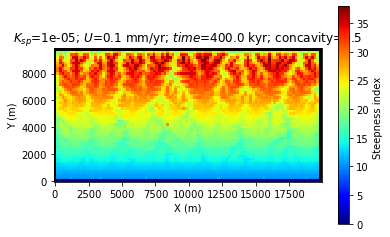

In [109]:
times = [1e5, 1e5, 1e5, 1e5]
for time in times:
    evolve_2(time= time, scenario="gradient")
    # plot topography
    plot_topography(raster2)
    # plot stuff
    plot_chi(1, raster2, cf2, omit_profiles=True)
    plot_steepness(1, raster2, sf2, omit_profiles=True)


#### 8. **Final Reflection.** 

Was your initial insight into how parameters would affect the landscape correct? Discuss in 6 sentences or less.